## Importing Packages ##

In [1]:
import os
import sys
import subprocess
import tempfile
import random
from itertools import compress
import os.path as op
import numpy as np
import skimage.io as sio
import pandas as pd
import importlib
import math
from math import sqrt
import matplotlib.pyplot as plt
from os import listdir, getcwd, chdir
from os.path import isfile, join
from sklearn import linear_model
from sklearn import svm
import diff_classifier
import diff_classifier.utils as ut
import diff_classifier.msd as msd
import diff_classifier.features as ft
import diff_classifier.heatmaps as hm
import diff_classifier.aws as aws

## Defining filename and importing video - will eventually convert to a for loop to loop through list of videos ##

In [18]:
tiffname = 'P10F_10uM_7DIV_40nm_slice_1_midbrain_vid_2.tif'

In [19]:
os.getcwd()

'/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/notebooks/development/MPT_Data/Prelim data'

In [20]:
os.chdir('/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/notebooks/development/MPT_Data/Prelim Data/')
test = sio.imread('TIFS/'+tiffname)
oshape = test.shape
oshape

(651, 2044, 2048)

## Splitting original 2048x2044 video into smaller videos - takes the video imported just above and splits it into 64 256x256 smaller videos - could potentially adjust this to split into 25 or 36 vids, but for now keeping at 64 (easier to track the small vids) ##

In [21]:
test2 = np.zeros((oshape[0], 2048, 2048), dtype=test.dtype)
test2[0:oshape[0], 0:oshape[1], :] = test

new_image = np.zeros((oshape[0], 512, 512), dtype=test.dtype)
names = []

for row in range(4):
    for col in range(4):
        new_image = test2[:, row*512:(row+1)*512, col*512:(col+1)*512]
        current = tiffname.split('.tif')[0] + '_%s_%s.tif' % (row, col)
        sio.imsave(current, new_image)
        names.append(current)

<ipython-input-21-0684185dcda2>:11: UserWarning: P10F_10uM_7DIV_40nm_slice_1_midbrain_vid_2_0_0.tif is a low contrast image
  sio.imsave(current, new_image)
<ipython-input-21-0684185dcda2>:11: UserWarning: P10F_10uM_7DIV_40nm_slice_1_midbrain_vid_2_0_1.tif is a low contrast image
  sio.imsave(current, new_image)
<ipython-input-21-0684185dcda2>:11: UserWarning: P10F_10uM_7DIV_40nm_slice_1_midbrain_vid_2_0_2.tif is a low contrast image
  sio.imsave(current, new_image)
<ipython-input-21-0684185dcda2>:11: UserWarning: P10F_10uM_7DIV_40nm_slice_1_midbrain_vid_2_0_3.tif is a low contrast image
  sio.imsave(current, new_image)
<ipython-input-21-0684185dcda2>:11: UserWarning: P10F_10uM_7DIV_40nm_slice_1_midbrain_vid_2_1_0.tif is a low contrast image
  sio.imsave(current, new_image)
<ipython-input-21-0684185dcda2>:11: UserWarning: P10F_10uM_7DIV_40nm_slice_1_midbrain_vid_2_1_1.tif is a low contrast image
  sio.imsave(current, new_image)
<ipython-input-21-0684185dcda2>:11: UserWarning: P10F_10uM

## For now, tracking is done manually using the plugin TrackMate in ImageJ. The cells located below this can be used to rename the trajectory .csv files to the proper 'Traj_... .csv' format ##

In [ ]:
os.chdir('/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/notebooks/development/MPT_Data/Prelim Data/7DIV 10uM 12h post exp Traj csv')
os.getcwd()

In [ ]:
files = os.listdir()
print(files)

## Defining list of all small videos to be quantified (calculating msds and features) ##

In [6]:
filename = 'P10F_NT_4DIV_40nm_slice_1_midbrain_vid_2'
rows = 4
cols = 4
ires = (512, 512)
frames = 651
names = []
for i in range(0,rows):
    for j in range(0,cols):
        names.append('{}_{}_{}.tif'.format(filename, i, j))

In [7]:
names

['P10F_NT_4DIV_40nm_slice_1_midbrain_vid_2_0_0.tif',
 'P10F_NT_4DIV_40nm_slice_1_midbrain_vid_2_0_1.tif',
 'P10F_NT_4DIV_40nm_slice_1_midbrain_vid_2_0_2.tif',
 'P10F_NT_4DIV_40nm_slice_1_midbrain_vid_2_0_3.tif',
 'P10F_NT_4DIV_40nm_slice_1_midbrain_vid_2_1_0.tif',
 'P10F_NT_4DIV_40nm_slice_1_midbrain_vid_2_1_1.tif',
 'P10F_NT_4DIV_40nm_slice_1_midbrain_vid_2_1_2.tif',
 'P10F_NT_4DIV_40nm_slice_1_midbrain_vid_2_1_3.tif',
 'P10F_NT_4DIV_40nm_slice_1_midbrain_vid_2_2_0.tif',
 'P10F_NT_4DIV_40nm_slice_1_midbrain_vid_2_2_1.tif',
 'P10F_NT_4DIV_40nm_slice_1_midbrain_vid_2_2_2.tif',
 'P10F_NT_4DIV_40nm_slice_1_midbrain_vid_2_2_3.tif',
 'P10F_NT_4DIV_40nm_slice_1_midbrain_vid_2_3_0.tif',
 'P10F_NT_4DIV_40nm_slice_1_midbrain_vid_2_3_1.tif',
 'P10F_NT_4DIV_40nm_slice_1_midbrain_vid_2_3_2.tif',
 'P10F_NT_4DIV_40nm_slice_1_midbrain_vid_2_3_3.tif']

## Calculating MSDs and features for the videos that have been tracked. This uses the Traj .csv files and generates an msd and features .csv file for the videos being quantified. It uses the multiple small vid Traj .csv files to generate a single msd and features .csv file. Essentially, this runs the kn.assemble_msds() function ##

In [8]:
os.chdir('/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/notebooks/development/MPT_Data/Prelim Data/NT 4DIV Traj csv')
msd_file = 'msd_{}.csv'.format(filename)
ft_file = 'features_{}.csv'.format(filename)

counter = 0
for name in names:
    try:
        row = int(name.split(filename)[1].split('.')[0].split('_')[1])
        col = int(name.split(filename)[1].split('.')[0].split('_')[2])

        traj_file = "Traj_{}_{}_{}.csv".format(filename, row, col)
        local_name = traj_file
    
        if counter == 0:
            to_add = pd.read_csv(local_name)
            del to_add['Label']
            del to_add['POSITION_Z']
            del to_add['POSITION_T']
            del to_add['RADIUS']
            del to_add['VISIBILITY']
            del to_add['MANUAL_COLOR']
            del to_add['MEDIAN_INTENSITY']
            del to_add['MIN_INTENSITY']
            del to_add['MAX_INTENSITY']
            del to_add['TOTAL_INTENSITY']
            del to_add['STANDARD_DEVIATION']
            del to_add['ESTIMATED_DIAMETER']
            del to_add['CONTRAST']
            to_add = to_add.rename(columns={'ID':'Spot_ID', 'TRACK_ID':'Track_ID','QUALITY':'Quality','FRAME':'Frame', 'POSITION_X':'X','POSITION_Y':'Y', 'MEAN_INTENSITY':'Mean_Intensity', 'SNR':'SN_Ratio'})
            to_add.sort_values(['Track_ID', 'Frame'], ascending=[1,1])
            to_add = to_add.astype('float64')

            partids = to_add.Track_ID.unique()
            counter = 0
            for partid in partids:
                to_add.loc[to_add.Track_ID == partid, 'Track_ID'] = counter
                counter = counter +1
            to_add['X'] = to_add['X'] + ires[0]*col
            to_add['Y'] = ires[1]-to_add['Y']+ires[1]*(rows-1-row)
            merged = msd.all_msds2(to_add, frames=frames)
            print("Finished with row 0 col 0")

        else:
        
            if merged.shape[0] > 0:
                to_add = pd.read_csv(local_name)
                del to_add['Label']
                del to_add['POSITION_Z']
                del to_add['POSITION_T']
                del to_add['RADIUS']
                del to_add['VISIBILITY']
                del to_add['MANUAL_COLOR']
                del to_add['MEDIAN_INTENSITY']
                del to_add['MIN_INTENSITY']
                del to_add['MAX_INTENSITY']
                del to_add['TOTAL_INTENSITY']
                del to_add['STANDARD_DEVIATION']
                del to_add['ESTIMATED_DIAMETER']
                del to_add['CONTRAST']
                to_add = to_add.rename(columns={'ID':'Spot_ID', 'TRACK_ID':'Track_ID','QUALITY':'Quality','FRAME':'Frame', 'POSITION_X':'X','POSITION_Y':'Y', 'MEAN_INTENSITY':'Mean_Intensity', 'SNR':'SN_Ratio'})
                to_add.sort_values(['Track_ID', 'Frame'], ascending=[1,1])
                to_add = to_add.astype('float64')

                partids = to_add.Track_ID.unique()
                counter = 0
                for partid in partids:
                    to_add.loc[to_add.Track_ID == partid, 'Track_ID'] = counter
                    counter = counter +1
                to_add['X'] = to_add['X'] + ires[0]*col
                to_add['Y'] = ires[1] - to_add['Y'] + ires[1]*(rows-1-row)
                to_add['Track_ID'] = to_add['Track_ID'] + max(merged['Track_ID']) +1
            
            else:
                to_add = pd.read_csv(local_name)
                del to_add['Label']
                del to_add['POSITION_Z']
                del to_add['POSITION_T']
                del to_add['RADIUS']
                del to_add['VISIBILITY']
                del to_add['MANUAL_COLOR']
                del to_add['MEDIAN_INTENSITY']
                del to_add['MIN_INTENSITY']
                del to_add['MAX_INTENSITY']
                del to_add['TOTAL_INTENSITY']
                del to_add['STANDARD_DEVIATION']
                del to_add['ESTIMATED_DIAMETER']
                del to_add['CONTRAST']
                to_add = to_add.rename(columns={'ID':'Spot_ID', 'TRACK_ID':'Track_ID','QUALITY':'Quality','FRAME':'Frame', 'POSITION_X':'X','POSITION_Y':'Y', 'MEAN_INTENSITY':'Mean_Intensity', 'SNR':'SN_Ratio'})
                to_add.sort_values(['Track_ID', 'Frame'], ascending=[1,1])
                to_add = to_add.astype('float64')

                partids = to_add.Track_ID.unique()
                counter = 0
                for partid in partids:
                    to_add.loc[to_add.Track_ID == partid, 'Track_ID'] = counter
                    counter = counter +1
                to_add['X'] = to_add['X'] + ires[0]*col
                to_add['Y'] = ires[1] - to_add['Y'] + ires[1]*(rows-1-row)
                to_add['Track_ID'] = to_add['Track_ID']
            
            merged = merged.append(msd.all_msds2(to_add, frames=frames))
            print('Done calculating MSDs for row {} and col {}'.format(row, col))
    
        counter = counter +1
    
        merged.to_csv(msd_file)
        merged_ft = ft.calculate_features(merged)
        merged_ft.to_csv(ft_file)
    
    except pd.errors.EmptyDataError:
        print('Found empty file : {}'.format(name))

Finished with row 0 col 0
Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Done calculating MSDs for row 0 and col 1
Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: Runtime

Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Done calculating MSDs for row 0 and col 2
Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: Runtime

Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Done calculating MSDs for row 0 and col 3
Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: Runtime

Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Done calculating MSDs for row 1 and col 0
Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: Runtime

Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:717: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = (dframe['MSDs'][fram1]/dframe['MSDs'][fram2]) - (


Done calculating MSDs for row 1 and col 1
Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: Runtime

Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:717: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = (dframe['MSDs'][fram1]/dframe['MSDs'][fram2]) - (


Optimal parameters not found. Print NaN instead.
Done calculating MSDs for row 1 and col 2
Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: Runtime

Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:717: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = (dframe['MSDs'][fram1]/dframe['MSDs'][fram2]) - (


Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Done calculating MSDs for row 1 and col 3
Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: Runtime

Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:717: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = (dframe['MSDs'][fram1]/dframe['MSDs'][fram2]) - (


Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Done calculating MSDs for row 2 and col 0
Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: Runtime

Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:717: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = (dframe['MSDs'][fram1]/dframe['MSDs'][fram2]) - (


Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Done calculating MSDs for row 2 and col 1
Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: Runtime

Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:717: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = (dframe['MSDs'][fram1]/dframe['MSDs'][fram2]) - (


Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: Runtime

Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Done calculating MSDs for row 2 and col 2
Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: Runtime

Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:717: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = (dframe['MSDs'][fram1]/dframe['MSDs'][fram2]) - (


Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: Runtime

Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Done calculating MSDs for row 2 and col 3
Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: Runtime

Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:717: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = (dframe['MSDs'][fram1]/dframe['MSDs'][fram2]) - (


Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: Runtime

Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Done calculating MSDs for row 3 and col 0
Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: Runtime

Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:717: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = (dframe['MSDs'][fram1]/dframe['MSDs'][fram2]) - (


Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: Runtime

Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.
Done calculating MSDs for row 3 and col 1
Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: Runtime

Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:717: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = (dframe['MSDs'][fram1]/dframe['MSDs'][fram2]) - (


Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: Runtime

Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Done calculating MSDs for row 3 and col 2
Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: Runtime

Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:717: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = (dframe['MSDs'][fram1]/dframe['MSDs'][fram2]) - (


Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: Runtime

Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.
Done calculating MSDs for row 3 and col 3
Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: Runtime

Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:717: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = (dframe['MSDs'][fram1]/dframe['MSDs'][fram2]) - (


Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: Runtime

Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height
/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.


/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.


msd_P10F_NT_4DIV_40nm_slice_1_midbrain_vid_2.csv
Plotted P10F_NT_4DIV_40nm_slice_1_midbrain_vid_2 trajectories successfully.
Successfully generated trajectory plot for P10F_NT_4DIV_40nm_slice_1_midbrain_vid_2
Successfully generated csv files for P10F_NT_4DIV_40nm_slice_1_midbrain_vid_2


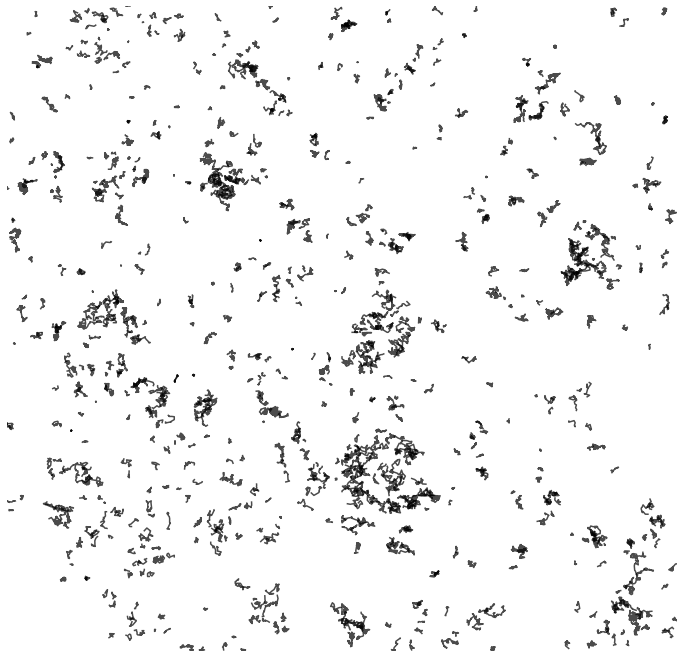

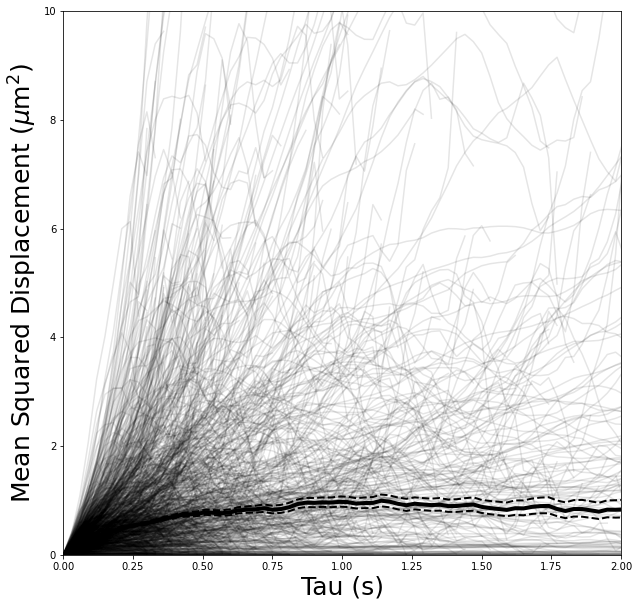

In [9]:
os.chdir('/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/notebooks/development/MPT_Data/Prelim Data/NT 4DIV Traj csv')
prefix = 'P10F_NT_4DIV_40nm_slice_1_midbrain_vid_2'
msds = 'msd_{}.csv'.format(prefix)
feat = 'features_{}.csv'.format(prefix)
print(msds)
hm.plot_trajectories(prefix, resolution=512, rows=4, cols=4, upload=False, figsize=(12, 12), bucket = 'mckenna.data')
print('Successfully generated trajectory plot for {}'.format(prefix))
geomean, geoSEM = hm.plot_individual_msds(prefix, x_range=2, y_range=10, umppx=0.07, fps=33.33, upload=False, bucket='mckenna.data')
print('Successfully generated csv files for {}'.format(prefix))